---
title: Atomic potentials
authors: [Toma Susi]
date: 2023/08/23
---

Updated by Georgios Varnavides, 2024/07/15

In [1]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np 

import abtem
from ase import Atoms

## Parametrized potentials

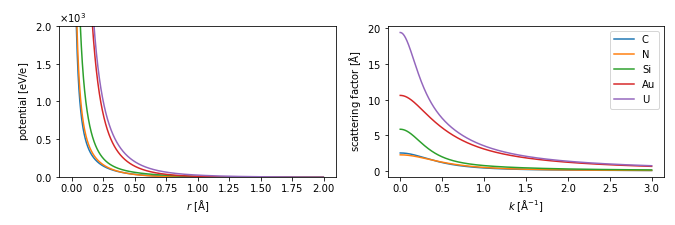

In [5]:
#| label: parametrized_potentials
symbols = ["C", "N", "Si", "Au", "U"]

parametrization = abtem.parametrizations.LobatoParametrization()

potentials = parametrization.line_profiles(symbols, cutoff=2, name="potential")
scattering_factor = parametrization.line_profiles(
    symbols, cutoff=3, name="scattering_factor"
)

dpi = 72
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(675/dpi, 225/dpi), dpi=dpi)

visualization = potentials.show(ax=ax1)
visualization.set_ylim([0, 2e3])

scattering_factor.show(legend=True, ax=ax2)

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '250px'
fig.canvas.toolbar_position = 'bottom'

fig.tight_layout();

In [3]:
pots = []
scat = []
symb = []

parametrization = abtem.parametrizations.LobatoParametrization()

for Z in range(33)[1:]:
    atoms = Atoms(numbers=[Z])
    
    potential = parametrization.line_profiles(atoms.symbols[0], cutoff=2, name="potential")
    scattering_factor = parametrization.line_profiles(
    atoms.symbols[0], cutoff=3, name="scattering_factor"
    )
    pots.append(potential)
    scat.append(scattering_factor)
    symb.append(atoms.symbols[0])

In [4]:
potentials = abtem.stack(pots, symb)
scattering_factors = abtem.stack(scat, symb)

In [5]:
# potentials.show(interact=True)

## Comparison of potentials for H atom

In [6]:
from ase import Atoms
from ase.units import Bohr
from numpy import pi, exp

q = 1.602176*10**-19; # Coulomb constant
eps0 = 8.854188*10**-12; # Dielectric constant

In [7]:
# Size of the unit cell (Ångstrom)
a = 8.0

# Defining a single H atom at the corner of the cell.
atoms = Atoms('H', positions=[(0,0,0)], cell=(a, a, a))

In [8]:
# Loading a radial line profile calculated for this atom with GPAW.
line_dft = np.load('data/H_atom_radial_potential_DFT.npy')

In [9]:
# Exact solution of the electrostatic potential of hydrogen converted to Ångström.

r = np.linspace(0, atoms.cell[0,0], line_dft.shape[0]) # Radial grid to match the DFT
y = q / (4 * pi * eps0) * (exp(-2 * r / Bohr) / r + exp(-2 * r / Bohr) / Bohr)  * 1e10;

/tmp/ipykernel_77981/4172123578.py:4: RuntimeWarning: divide by zero encountered in divide
  y = q / (4 * pi * eps0) * (exp(-2 * r / Bohr) / r + exp(-2 * r / Bohr) / Bohr)  * 1e10;


In [10]:
# Loading the Kirkland IAM potential from abTEM.
parametrization = abtem.parametrizations.KirklandParametrization()
potential = parametrization.potential('H')
line_iam = potential(r) # Radial potential matching given grid.

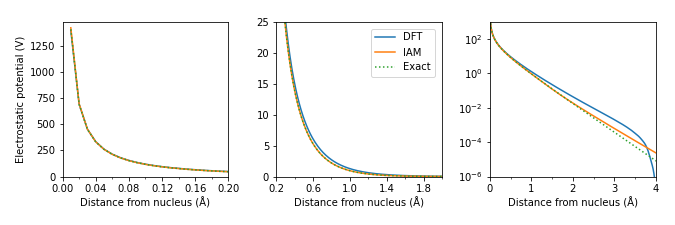

In [11]:
#| label: H_potential_comparisons
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Plotting the comparison between the three models.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(675/dpi, 225/dpi), dpi=dpi)

ax1.set_xlim((0.0,0.2));
ax1.set_ylim((0,y[1]*1.05));
ax1.plot(r[1:], line_dft[1:], label='DFT')
ax1.plot(r[1:], line_iam[1:], label='IAM')
ax1.plot(r[1:], y[1:], label='Exact', linestyle=':');
ax1.set_xlabel('Distance from nucleus (Å)')
ax1.set_ylabel('Electrostatic potential (V)')
ax1.set_xticks(np.arange(0,0.24,0.04))
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))

ax2.set_xlim((0.2,2.0));
ax2.set_ylim((0.0,25.0));
ax2.plot(r[1:], line_dft[1:])#, label='DFT')
ax2.plot(r[1:], line_iam[1:])#, label='IAM')
ax2.plot(r[1:], y[1:], linestyle=':')#, label='Exact');
ax2.set_xlabel('Distance from nucleus (Å)')
ax2.set_xticks(np.arange(0.2,2.2,0.4))
ax2.xaxis.set_minor_locator(MultipleLocator(0.2))

ax3.set_xlim((0.0,4.0));
ax3.set_ylim((0.000001,1000));
ax3.plot(r[1:], line_dft[1:])#, label='DFT')
ax3.plot(r[1:], line_iam[1:])#, label='IAM')
ax3.plot(r[1:], y[1:], linestyle=':')#, label='Exact');
ax3.set_yscale('log')
ax3.set_xlabel('Distance from nucleus (Å)')
ax3.xaxis.set_minor_locator(MultipleLocator(0.5))

fig.legend(loc=(0.55,0.66));

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '250px'
fig.canvas.toolbar_position = 'bottom'
fig.tight_layout(pad=1.6)

## H2 molecule

In [12]:
a = 12.  # Size of unit cell (Angstrom)
c = a / 2 # Center

# Hydrogen molecule equilibrium bond length
d = 0.75  
distances = np.arange(0.75,3.25,0.25)

ats = []

for i in np.arange(len(distances)):
    
    d = distances[i]
    
    # Set up an two H atoms at a distance d.
    atoms = Atoms('H2',
                  positions=([c - d / 2, c/2, c],
                             [c + d / 2, c/2, c]),
                  cell=(a, a/2, a))
    ats.append(atoms)

In [13]:
iamstack = abtem.from_zarr('data/H2_IAM_dists.zarr').project()
dftstack = abtem.from_zarr('data/H2_DFT_dists.zarr').project()

diffstack = (iamstack-dftstack)

TypeError: OrdinalAxis.__init__() got an unexpected keyword argument '_tex_label'

In [14]:
#| label: H2_potential
diffstack.show(cbar=True, title="Hydrogen molecule (IAM-DFT)")

NameError: name 'diffstack' is not defined